In [1]:
import os
import datetime
import seaborn as sns
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/rl_sim/thesis_ws/src/ML/UTILITIES')
from PreProcessingFunctions import myfilter, num_transient, sliding_sum_window, select_index, add_padding
from PreProcessingFunctions import WS, WS_B
from PreProcessingFunctions import rename_and_convert_to_txt

from OrganizeReports import compare_and_organize
from Performance_plotter import plot_f1_score_threshold, plot_precision_recall_curve, plot_confusion_matrix, plot_roc_curve
from ML_models_functions import to_save_model, save_summary_and_results

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, roc_auc_score

import tensorflow
from tensorflow.keras.models import save_model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

tensorflow.config.list_physical_devices('GPU')
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
if gpus:    # Restrict TensorFlow to only allocate memory on the GPU dynamically
    for gpu in gpus:
        tensorflow.config.experimental.set_memory_growth(gpu, True)
    tensorflow.config.experimental.set_visible_devices(gpus[0], 'GPU')

from tensorflow.keras.models        import Sequential, Model, load_model
from tensorflow.keras.initializers  import GlorotUniform
from tensorflow.keras.layers        import Input, Conv1D, Conv2D, BatchNormalization
from tensorflow.keras.layers        import Flatten, Dense, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D
from tensorflow.keras.layers        import LeakyReLU, ReLU, Activation, Dropout, Lambda
from tensorflow.keras.layers        import concatenate, Concatenate
from tensorflow.keras.optimizers    import Adam
from tensorflow.keras.losses        import BinaryCrossentropy
from tensorflow.keras.metrics       import AUC, Precision, Recall

from tensorflow.keras.utils         import plot_model


folder_path = '/home/rl_sim/thesis_ws/src/RobotData_GRIPA320'
data_folder = '/home/rl_sim/thesis_ws/src/ML/DATA/1D_TRANSF_FTP_NotNorm'

def load_data(data_folder):
    X_data = []
    y_data = []
    
    # Traverse the data folder
    for file in os.listdir(data_folder):
        if file.endswith(".npz"):
            file_path = os.path.join(data_folder, file)
            data = np.load(file_path)
            X_data.append(data['X'])
            y_data.append(data['y'])
    
    # Stack the data into arrays
    X_data = np.vstack(X_data)
    y_data = np.hstack(y_data)
    
    return X_data, y_data

# Load the data
X_data, y_data = load_data(data_folder)

# Check the shape of loaded data
print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)
print("X_data.[0] shape: ", X_data[0].shape)

X_data = np.dstack((X_data[:, :, 2], X_data[:, :, 0], X_data[:, :, 6], X_data[:, :, 7],X_data[:, :, 8]))
print("\nSelectedInputs: ", X_data.shape)
print("SelectedInputs: ", X_data[0].shape)

TEST_SIZE = 0.4
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"\nTOTAL DATA: {len(X_data)}  ||  Train = {100*(1-TEST_SIZE)}%  ||  Test = {100*TEST_SIZE}%")
print("Dimensions of X_train:", X_train.shape, "   ||  Dimensions of y_train:", y_train.shape)
print("Dimensions of X_test: ", X_test.shape, "   ||  Dimensions of y_test: ", y_test.shape)
print("Dimensions of X_val:  ", X_val.shape, "   ||  Dimensions of y_val:  ", y_val.shape)
print("X_train shape:", X_train.shape)

IN_SHAPE = (WS_B, 5) #X_data[0].shape
TYPEm = "ANN_G"

2024-08-30 17:58:23.651926: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-30 17:58:23.677007: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-30 17:58:24.089256: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-08-30 17:58:24.385077: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more 

X_data shape: (1465, 800, 9)
y_data shape: (1465,)
X_data.[0] shape:  (800, 9)

SelectedInputs:  (1465, 800, 5)
SelectedInputs:  (800, 5)

TOTAL DATA: 1465  ||  Train = 60.0%  ||  Test = 40.0%
Dimensions of X_train: (879, 800, 5)    ||  Dimensions of y_train: (879,)
Dimensions of X_test:  (293, 800, 5)    ||  Dimensions of y_test:  (293,)
Dimensions of X_val:   (293, 800, 5)    ||  Dimensions of y_val:   (293,)
X_train shape: (879, 800, 5)


# EAIEST FF-ANN

2024-08-30 17:58:24.683890: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-30 17:58:24.684097: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-30 17:58:24.684217: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 800, 5)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,024,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,092,353 (4.17 MB)

 Trainable params: 1,091,329 (4.16 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/25


I0000 00:00:1725033505.296450  661367 service.cc:145] XLA service 0x7fbe580054a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725033505.296486  661367 service.cc:153]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2024-08-30 17:58:25.313222: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-30 17:58:25.395449: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 1/28 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5000 - loss: 0.9343

I0000 00:00:1725033506.053537  661367 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6661 - loss: 0.7473 - val_accuracy: 0.7065 - val_loss: 0.9534
Epoch 2/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7900 - loss: 0.4575 - val_accuracy: 0.6826 - val_loss: 0.9494
Epoch 3/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8523 - loss: 0.3686 - val_accuracy: 0.7167 - val_loss: 0.8147
Epoch 4/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8155 - loss: 0.3999 - val_accuracy: 0.6928 - val_loss: 1.0394
Epoch 5/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8134 - loss: 0.4112 - val_accuracy: 0.7577 - val_loss: 0.7250
Epoch 6/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8346 - loss: 0.3976 - val_accuracy: 0.8020 - val_loss: 0.4168
Epoch 7/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8614 - loss: 0.3650 - val_accuracy: 0.7577 - val_loss: 0.4457
Epoch 8/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8459 - loss: 0.3460 - val_accuracy: 0.6451 - val_loss: 0.7311
Ep

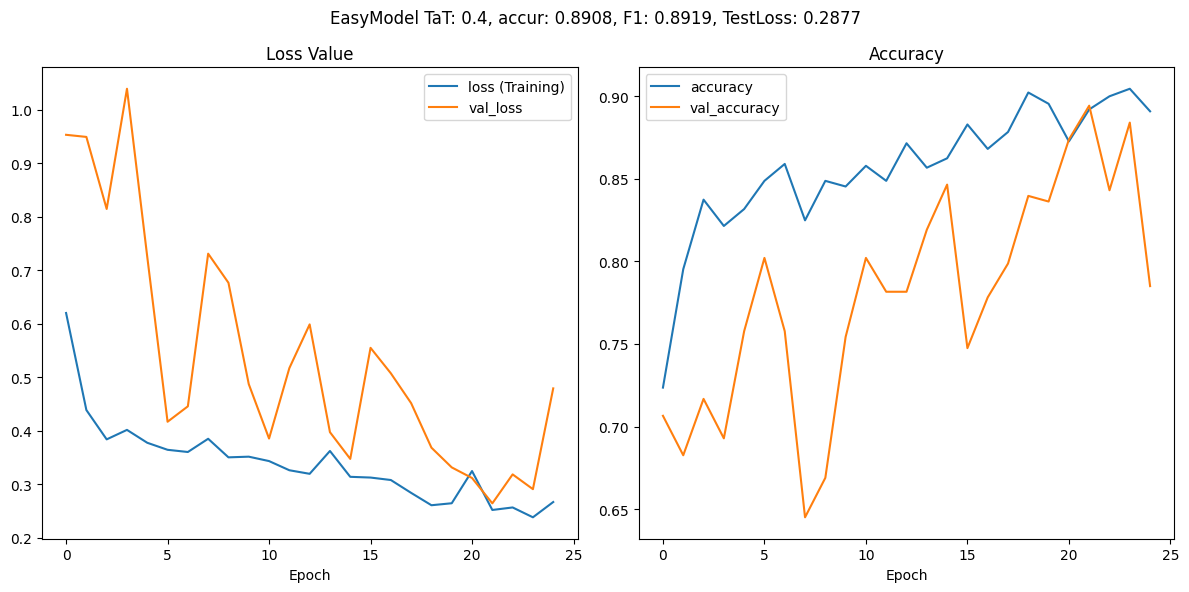

Train loss: 0.26675620675086975
Test val_loss: 0.47923681139945984
Train accuracy: 0.8907849788665771
Accuracy Score: 0.8907849829351536
F1 Score: 0.8918918918918919
Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.94      0.89       137
         1.0       0.94      0.85      0.89       156

    accuracy                           0.89       293
   macro avg       0.89      0.89      0.89       293
weighted avg       0.90      0.89      0.89       293



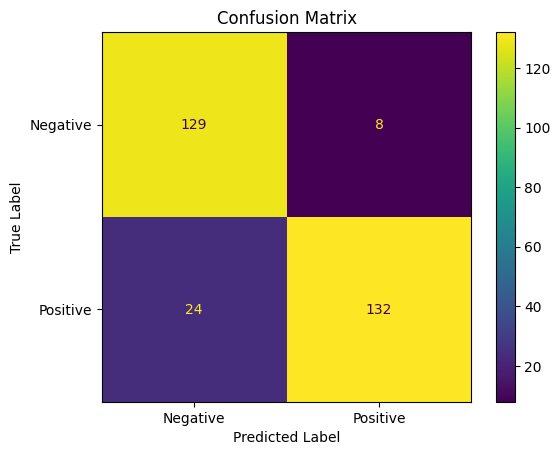

In [2]:
def build_ff_ann():
    inputs = Input(shape=IN_SHAPE)
    x = Flatten()(inputs)  # Flatten the input to (800*5,)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    outputs = Dense(1, activation='sigmoid')(x)  # Output layer for binary classification
    model = Model(inputs, outputs)
    return model


model = build_ff_ann()
model.summary()
model.compile(optimizer=Adam(learning_rate=0.004), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val), 
                    callbacks=[early_stopping], verbose=1) 

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

plot_confusion_matrix(y_test, y_pred_binary)

In [3]:
model_name = f"FF_{TYPEm}_2LAyerModel_v1"
from ML_models_functions import save_summary_and_results
save_summary_and_results(model, history, loss, accuracy, f1, model_name, y_test, y_pred_binary, build_ff_ann)
# Save the model separately
save_dir = "saved_models/"
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, f"{model_name}.keras")
save_model(model, model_path)

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - auc: 0.9591 - loss: 0.2584 - val_auc: 0.8377 - val_loss: 0.6690
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9478 - loss: 0.2969 - val_auc: 0.9117 - val_loss: 0.4169
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9432 - loss: 0.3072 - val_auc: 0.9298 - val_loss: 0.3402
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9537 - loss: 0.2773 - val_auc: 0.9360 - val_loss: 0.3996
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9711 - loss: 0.2140 - val_auc: 0.9591 - val_loss: 0.2627
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9714 - loss: 0.2210 - val_auc: 0.9448 - val_loss: 0.3375
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9486 - loss: 0.2903 - val_auc: 0.9155 - val_loss: 0.3831
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9508 - loss: 0.2927 - val_auc: 0.9017 - val_loss: 0.4865
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9615 - loss:

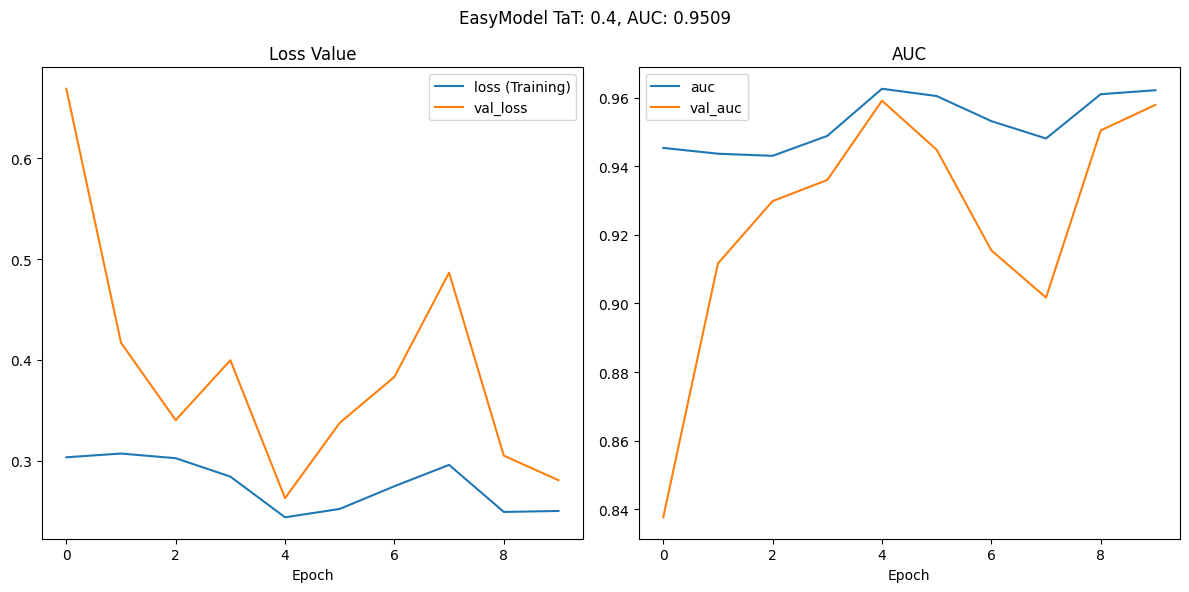

Train loss: 0.25000858306884766
Test val_loss: 0.2805761396884918
AUC: 0.9509170877784017
Classification Report:
               precision    recall  f1-score   support

         0.0       0.78      0.95      0.86       137
         1.0       0.94      0.77      0.85       156

    accuracy                           0.85       293
   macro avg       0.86      0.86      0.85       293
weighted avg       0.87      0.85      0.85       293



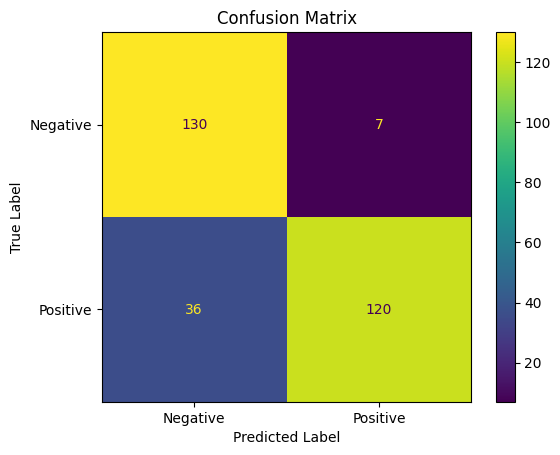

In [4]:
model.compile(optimizer=Adam(learning_rate=0.004), loss='binary_crossentropy', metrics=['auc'])  # Change metric to 'auc'
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate AUC
auc = roc_auc_score(y_test, y_pred)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot AUC
axs[1].plot(history.history["auc"], label="auc")
axs[1].plot(history.history["val_auc"], label="val_auc")
axs[1].set_title("AUC")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, AUC: {auc:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("AUC:", auc)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

plot_confusion_matrix(y_test, y_pred_binary)

# 'NORMAL' FF-ANN (few layers)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 800, 5)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     1,024,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,092,993 (4.17 MB)

 Trainable params: 1,091,713 (4.16 MB)

 Non-trainable params: 1,280 (5.00 KB)

Epoch 1/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.6140 - loss: 0.8471 - val_accuracy: 0.6143 - val_loss: 1.3107
Epoch 2/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7566 - loss: 0.5047 - val_accuracy: 0.6451 - val_loss: 0.8678
Epoch 3/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7897 - loss: 0.4649 - val_accuracy: 0.6382 - val_loss: 1.2583
Epoch 4/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7657 - loss: 0.4521 - val_accuracy: 0.7099 - val_loss: 0.7111
Epoch 5/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8046 - loss: 0.4419 - val_accuracy: 0.7543 - val_loss: 0.4677
Epoch 6/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8397 - loss: 0.3731 - val_accuracy: 0.7713 - val_loss: 0.6978
Epoch 7/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8410 - loss: 0.3828 - val_accuracy: 0.7201 - val_loss: 0.6431
Epoch 8/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8575 - loss: 0.3353 - val_accuracy: 0.7747 - val_loss

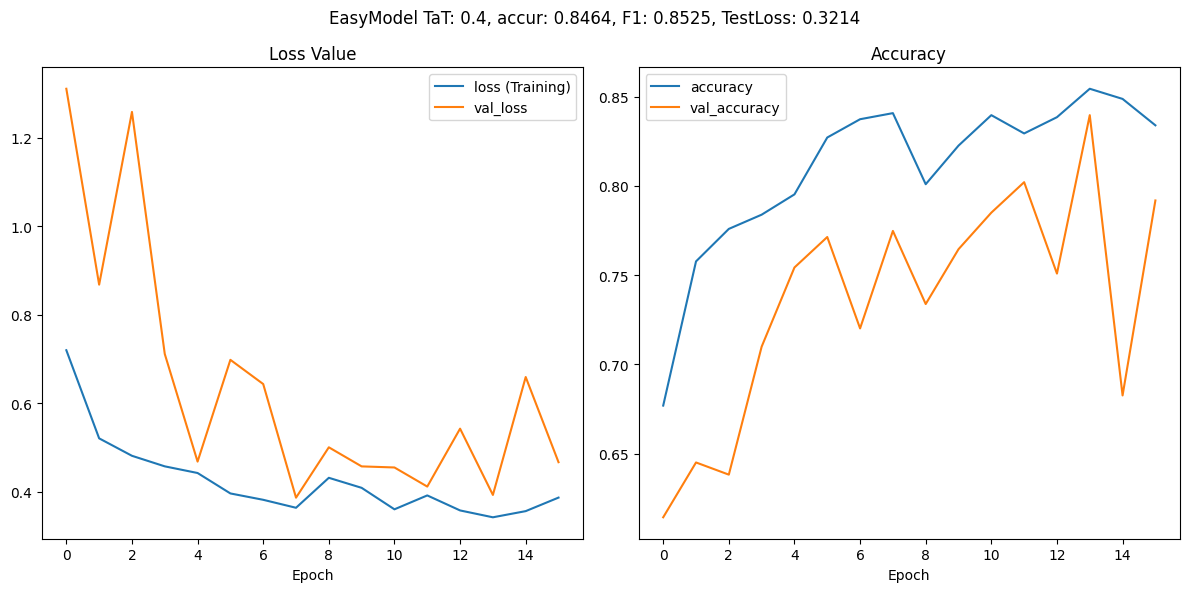

Train loss: 0.3863433599472046
Test val_loss: 0.46639806032180786
Train accuracy: 0.8339021801948547
Accuracy Score: 0.8464163822525598
F1 Score: 0.8524590163934426
Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.86      0.84       137
         1.0       0.87      0.83      0.85       156

    accuracy                           0.85       293
   macro avg       0.85      0.85      0.85       293
weighted avg       0.85      0.85      0.85       293



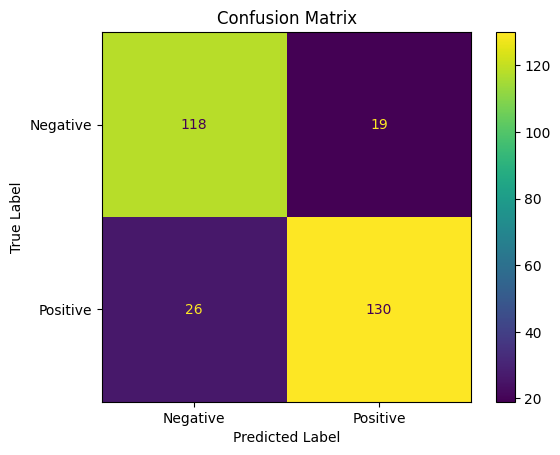

In [5]:
def build_ff_ann():
    inputs = Input(shape=IN_SHAPE)
    x = Flatten()(inputs)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    return model

model = build_ff_ann()
model.summary()
model.compile(optimizer=Adam(learning_rate=0.004), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val), 
                    callbacks=[early_stopping], verbose=1) 

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

plot_confusion_matrix(y_test, y_pred_binary)

In [6]:
# model_name = f"FF_{TYPEm}_4LayerModel_v1"
# from ML_models_functions import save_summary_and_results
# save_summary_and_results(model, history, loss, accuracy, f1, model_name, y_test, y_pred_binary, build_ff_ann)
# # Save the model separately
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 800, 5)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │     1,024,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,159,169 (4.42 MB)

 Trainable params: 1,157,633 (4.42 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/25


28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - auc: 0.6162 - loss: 5.4781 - val_auc: 0.5081 - val_loss: 8.3120
Epoch 2/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7018 - loss: 4.6791 - val_auc: 0.4949 - val_loss: 8.3708
Epoch 3/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.6669 - loss: 5.0710 - val_auc: 0.6136 - val_loss: 5.9421
Epoch 4/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7055 - loss: 4.5590 - val_auc: 0.5749 - val_loss: 6.7729
Epoch 5/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7163 - loss: 4.3164 - val_auc: 0.6688 - val_loss: 5.2657
Epoch 6/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7217 - loss: 4.3248 - val_auc: 0.6689 - val_loss: 5.1040
Epoch 7/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7186 - loss: 4.3151 - val_auc: 0.6018 - val_loss: 6.0221
Epoch 8/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.6552 - loss: 5.4568 - val_auc: 0.4938 - val_loss: 7.6491
Epoch 9/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.6323 - loss: 5.7580 - v

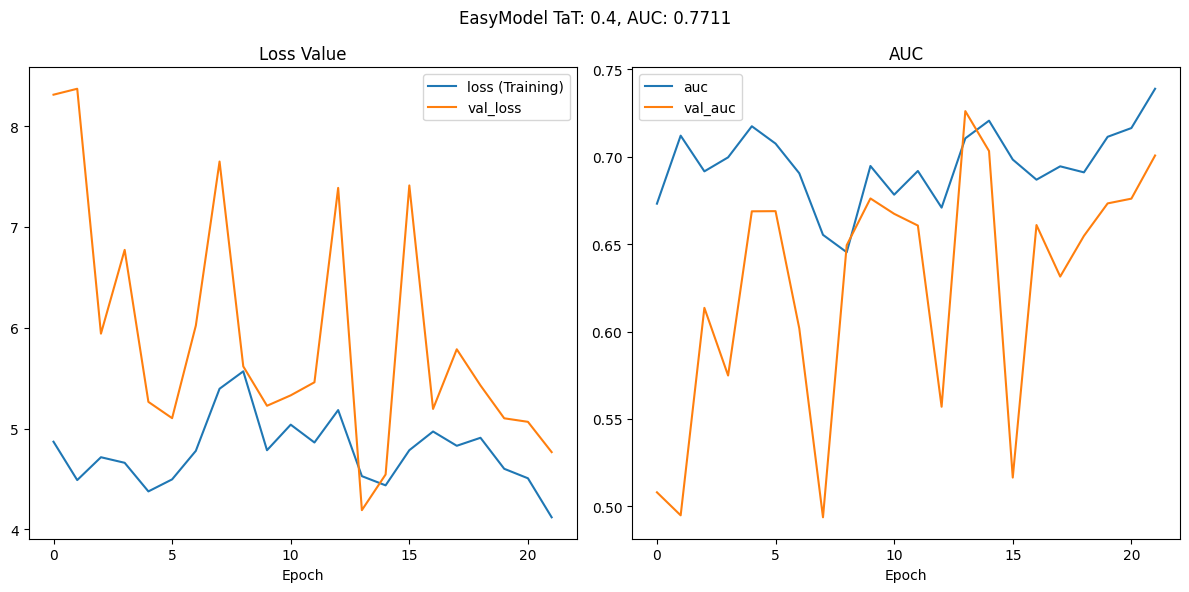

Train loss: 4.120901584625244
Test val_loss: 4.767280578613281
AUC: 0.7711257720381808
Classification Report:
               precision    recall  f1-score   support

         0.0       0.71      0.74      0.72       137
         1.0       0.76      0.73      0.75       156

    accuracy                           0.73       293
   macro avg       0.73      0.73      0.73       293
weighted avg       0.73      0.73      0.73       293



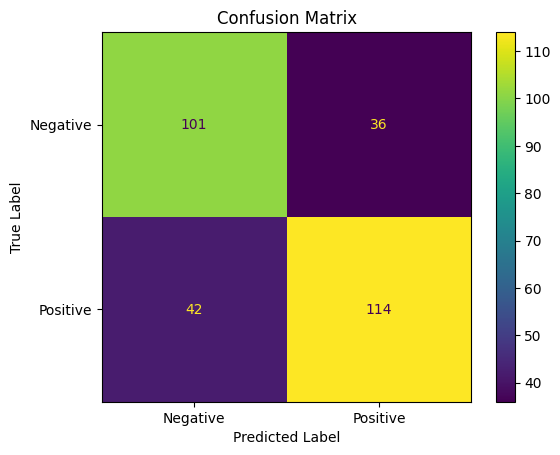

In [7]:
def build_ff_ann():
    inputs = Input(shape=IN_SHAPE)
    x = Flatten()(inputs)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    outputs = Dense(1, activation='relu')(x)

    model = Model(inputs, outputs)
    return model

model = build_ff_ann()
model.summary()
model.compile(optimizer=Adam(learning_rate=0.004), loss='binary_crossentropy', metrics=['auc'])  # Change metric to 'auc'
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val), 
                    callbacks=[early_stopping], verbose=1) 
# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate AUC
auc = roc_auc_score(y_test, y_pred)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot AUC
axs[1].plot(history.history["auc"], label="auc")
axs[1].plot(history.history["val_auc"], label="val_auc")
axs[1].set_title("AUC")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, AUC: {auc:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("AUC:", auc)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

plot_confusion_matrix(y_test, y_pred_binary)

In [8]:
# model_name = f"FF_{TYPEm}_3LayerModel_v1"
# from ML_models_functions import save_summary_and_results
# save_summary_and_results(model, history, loss, auc, f1, model_name, y_test, y_pred_binary, build_ff_ann)
# # Save the model separately
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

# COMPLEX-BULKY FF-ANN

/home/rl_sim/anaconda3/envs/tfenv/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 800, 5)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │     1,024,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,129,665 (4.31 MB)

 Trainable params: 1,128,385 (4.30 MB)

 Non-trainable params: 1,280 (5.00 KB)

Epoch 1/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.6754 - loss: 0.6162 - val_accuracy: 0.4608 - val_loss: 11.0236
Epoch 2/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7931 - loss: 0.4730 - val_accuracy: 0.5700 - val_loss: 1.5909
Epoch 3/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8022 - loss: 0.4375 - val_accuracy: 0.6280 - val_loss: 1.3095
Epoch 4/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8287 - loss: 0.3982 - val_accuracy: 0.6894 - val_loss: 0.7485
Epoch 5/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8098 - loss: 0.3858 - val_accuracy: 0.7235 - val_loss: 0.5767
Epoch 6/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8616 - loss: 0.3105 - val_accuracy: 0.7440 - val_loss: 0.4972
Epoch 7/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8483 - loss: 0.3431 - val_accuracy: 0.8259 - val_loss: 0.4319
Epoch 8/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8334 - loss: 0.3739 - val_accuracy: 0.7304 - val_los

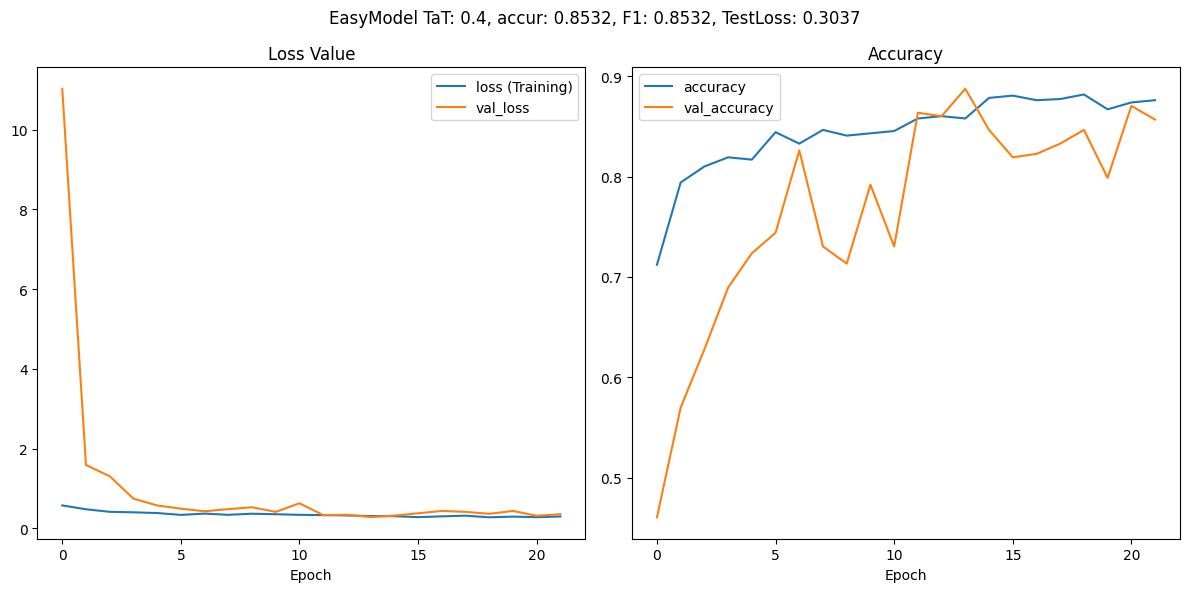

Train loss: 0.30089572072029114
Test val_loss: 0.35873156785964966
Train accuracy: 0.8759954571723938
Accuracy Score: 0.8532423208191127
F1 Score: 0.8532423208191127
Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.91      0.85       137
         1.0       0.91      0.80      0.85       156

    accuracy                           0.85       293
   macro avg       0.86      0.86      0.85       293
weighted avg       0.86      0.85      0.85       293



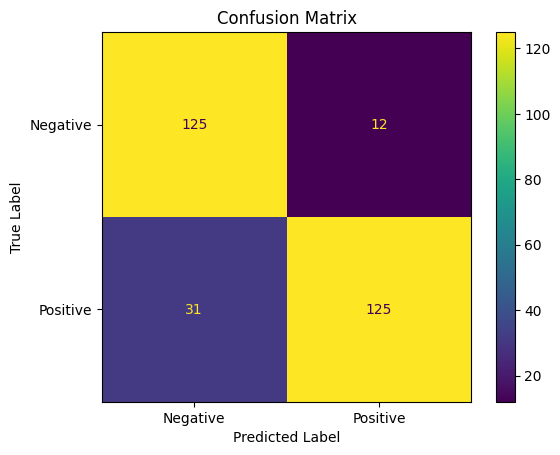

In [9]:

def build_ff_ann():
    inputs = Input(shape=IN_SHAPE)
    x = Flatten()(inputs)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Dense(32, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model

model = build_ff_ann()
model.summary()
model.compile(optimizer=Adam(learning_rate=0.004), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val), 
                    callbacks=[early_stopping], verbose=1) 

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

plot_confusion_matrix(y_test, y_pred_binary)

In [10]:
# model_name = f"FF_{TYPEm}_5LayerModel_v1"
# from ML_models_functions import save_summary_and_results
# save_summary_and_results(model, history, loss, accuracy, f1, model_name, y_test, y_pred_binary, build_ff_ann)
# # Save the model separately
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

Epoch 1/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - auc: 0.9159 - loss: 0.3667 - val_auc: 0.8134 - val_loss: 0.5263
Epoch 2/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9415 - loss: 0.3112 - val_auc: 0.7941 - val_loss: 1.0506
Epoch 3/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9482 - loss: 0.2890 - val_auc: 0.8316 - val_loss: 0.5337
Epoch 4/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9434 - loss: 0.3048 - val_auc: 0.8917 - val_loss: 0.4568
Epoch 5/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9478 - loss: 0.2926 - val_auc: 0.8561 - val_loss: 0.4630
Epoch 6/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9560 - loss: 0.2844 - val_auc: 0.8556 - val_loss: 0.5146
Epoch 7/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9469 - loss: 0.2921 - val_auc: 0.8466 - val_loss: 0.5097
Epoch 8/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9414 - loss: 0.3058 - val_auc: 0.8937 - val_loss: 0.4190
Epoch 9/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9572 - loss:

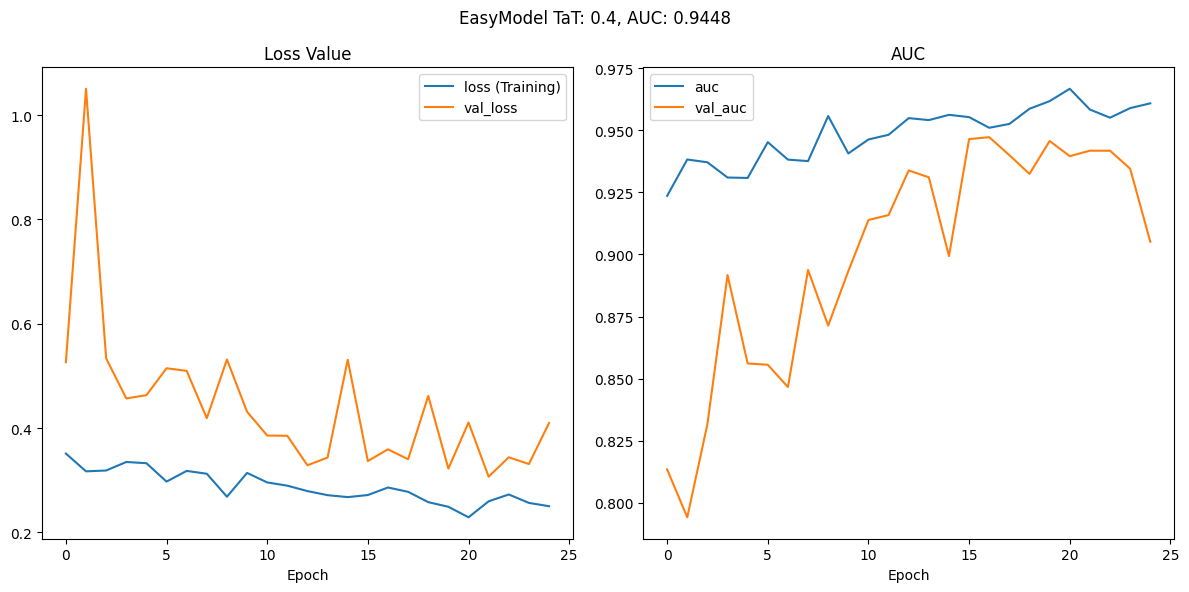

Train loss: 0.25018736720085144
Test val_loss: 0.4096713662147522
AUC: 0.9448343627175745
Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.89      0.87       137
         1.0       0.90      0.86      0.88       156

    accuracy                           0.87       293
   macro avg       0.87      0.87      0.87       293
weighted avg       0.87      0.87      0.87       293



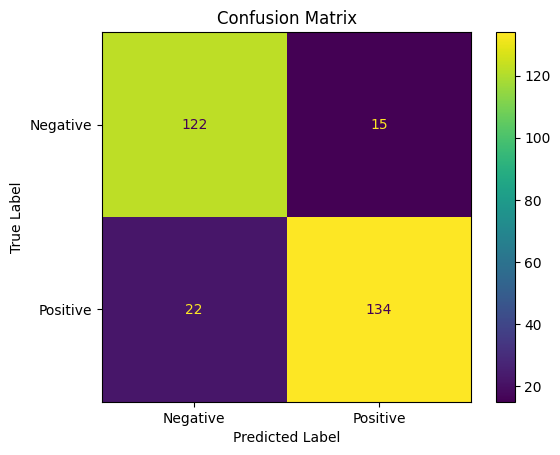

In [11]:
model.compile(optimizer=Adam(learning_rate=0.004), loss='binary_crossentropy', metrics=['auc'])  # Change metric to 'auc'
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val), 
                    callbacks=[early_stopping], verbose=1) 
# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate AUC
auc = roc_auc_score(y_test, y_pred)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot AUC
axs[1].plot(history.history["auc"], label="auc")
axs[1].plot(history.history["val_auc"], label="val_auc")
axs[1].set_title("AUC")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, AUC: {auc:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("AUC:", auc)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

plot_confusion_matrix(y_test, y_pred_binary)

In [12]:
# model_name = f"FF_{TYPEm}_Model_v1_AUCmetrics"
# from ML_models_functions import save_summary_and_results
# save_summary_and_results(model, history, loss, accuracy, f1, model_name, y_test, y_pred_binary, build_ff_ann)
# # Save the model separately
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

# BRANCHED ANN

/home/rl_sim/anaconda3/envs/tfenv/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 800, 5)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 4000)      │          0 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 256)       │  1,024,256 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 256)       │  1,024,256 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_16[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 128)       │    512,128 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 128)       │    512,128 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 256)       │          0 │ dense_24[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 128)       │          0 │ dense_18[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 128)       │          0 │ dense_20[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 64)        │    256,064 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 256)       │          0 │ leaky_re_lu_2[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 128)       │     32,896 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 64)        │      8,256 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 64)        │      8,256 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 32)        │      2,080 │ dense_22[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 64)        │     16,448 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 352)       │          0 │ dense_17[0][0],   │
│ (Concatenate)       │                   │            │ dense_19[0][0],   │
│                     │                   │            │ dense_21[0][0],   │
│                     │                   │            │ dense_23[0][0],   │
│                     │                   │            │ dense_25[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 3,421,857 (13.05 MB)

 Trainable params: 3,420,641 (13.05 MB)

 Non-trainable params: 1,216 (4.75 KB)

Epoch 1/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 0.6432 - loss: 0.7472 - val_accuracy: 0.6758 - val_loss: 1.4002
Epoch 2/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7804 - loss: 0.4932 - val_accuracy: 0.4710 - val_loss: 3.8777
Epoch 3/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7723 - loss: 0.4279 - val_accuracy: 0.7065 - val_loss: 1.0631
Epoch 4/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8237 - loss: 0.3972 - val_accuracy: 0.6485 - val_loss: 0.8823
Epoch 5/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8508 - loss: 0.3423 - val_accuracy: 0.7065 - val_loss: 0.8912
Epoch 6/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8406 - loss: 0.3649 - val_accuracy: 0.7747 - val_loss: 0.4700
Epoch 7/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8401 - loss: 0.3483 - val_accuracy: 0.6212 - val_loss: 1.0475
Epoch 8/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8591 - loss: 0.3114 - val_accuracy: 0.8294 - val_los

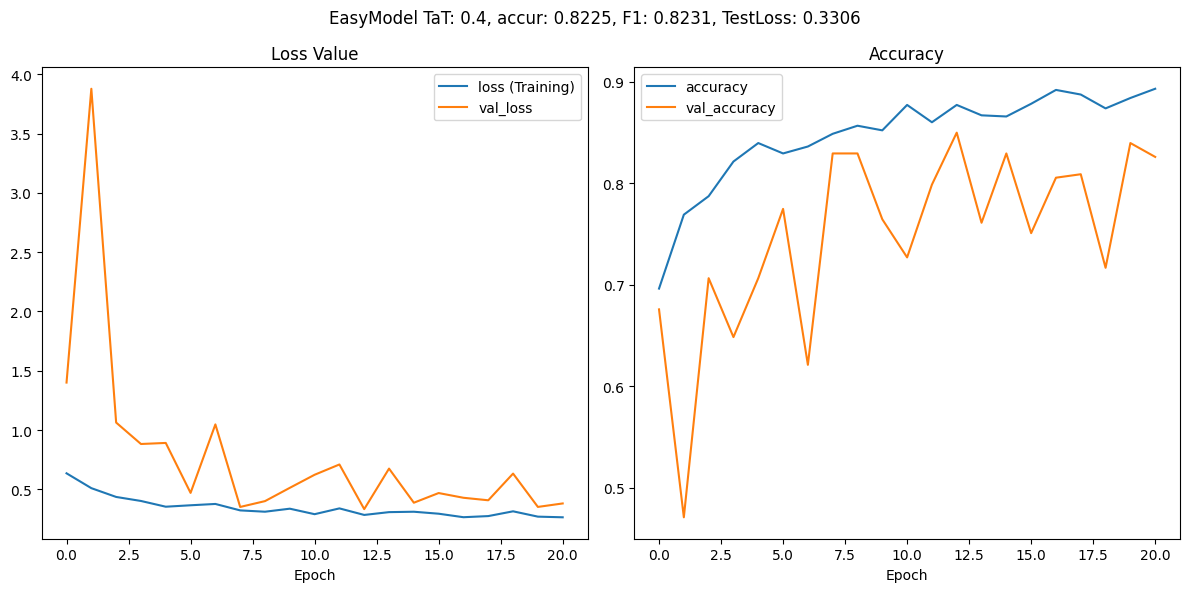

Train loss: 0.2642398774623871
Test val_loss: 0.38101035356521606
Train accuracy: 0.8930602669715881
Accuracy Score: 0.8225255972696246
F1 Score: 0.8231292517006803
Classification Report:
               precision    recall  f1-score   support

         0.0       0.77      0.88      0.82       137
         1.0       0.88      0.78      0.82       156

    accuracy                           0.82       293
   macro avg       0.83      0.83      0.82       293
weighted avg       0.83      0.82      0.82       293



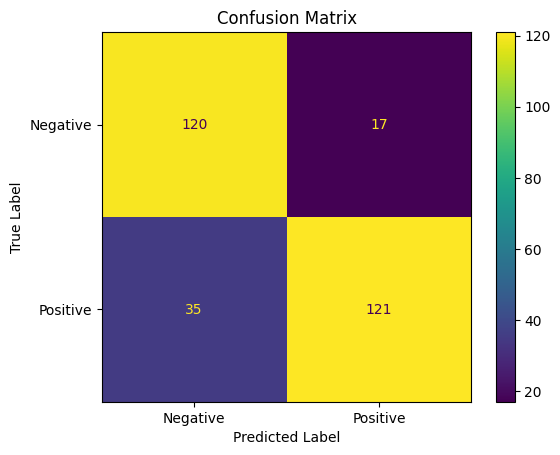

In [13]:
def build_ff_ann(input_shape=IN_SHAPE):
    input_layer = Input(shape=input_shape)
    flatten_layer = Flatten()(input_layer)
    
    # Branch 1
    branch1 = Dense(256, activation='relu')(flatten_layer)
    branch1 = BatchNormalization()(branch1)
    branch1 = Dropout(0.2)(branch1)
    branch1_output = Dense(128, activation='relu')(branch1)
    
    # Branch 2
    branch2 = Dense(128, activation='relu')(flatten_layer)
    branch2 = Dropout(0.2)(branch2)
    branch2_output = Dense(64, activation='relu')(branch2)
    
    # Branch 3
    branch3 = Dense(128, activation='relu')(flatten_layer)
    branch3 = Dropout(0.2)(branch3)
    branch3_output = Dense(64, activation='relu')(branch3)
    
    # Branch 4
    branch4 = Dense(64, activation='relu')(flatten_layer)
    branch4_output = Dense(32, activation='relu')(branch4)

    # Branch 5
    branch5 = Dense(256, kernel_initializer=GlorotUniform())(flatten_layer)
    branch5 = LeakyReLU(alpha=0.1)(branch5)
    branch5 = Dropout(0.2)(branch5)
    branch5_output = Dense(64, kernel_initializer=GlorotUniform(), activation='relu')(branch5)


    # Merge branches
    merged = concatenate([branch1_output, branch2_output, branch3_output, branch4_output, branch5_output])
    merged = BatchNormalization()(merged)
    merged = Dense(64, activation='relu')(merged)
    
    output_layer = Dense(1, activation='sigmoid')(merged)
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

model = build_ff_ann()
model.summary()
model.compile(optimizer=Adam(learning_rate=0.004), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val), 
                    callbacks=[early_stopping], verbose=1) 
loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

plot_confusion_matrix(y_test, y_pred_binary)

In [14]:
# model_name = f"FF_{TYPEm}_BRANCHEDModel_v1"
# from ML_models_functions import save_summary_and_results
# save_summary_and_results(model, history, loss, accuracy, f1, model_name, y_test, y_pred_binary, build_ff_ann)
# # Save the model separately
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

Epoch 1/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - auc: 0.9322 - loss: 0.3427 - val_auc: 0.7890 - val_loss: 1.2308
Epoch 2/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9393 - loss: 0.3141 - val_auc: 0.9013 - val_loss: 0.5715
Epoch 3/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9566 - loss: 0.2625 - val_auc: 0.8589 - val_loss: 0.6224
Epoch 4/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9627 - loss: 0.2448 - val_auc: 0.7352 - val_loss: 1.6603
Epoch 5/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9627 - loss: 0.2649 - val_auc: 0.9003 - val_loss: 0.4169
Epoch 6/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9491 - loss: 0.2970 - val_auc: 0.8038 - val_loss: 1.1207
Epoch 7/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9466 - loss: 0.2967 - val_auc: 0.8823 - val_loss: 0.4479
Epoch 8/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9572 - loss: 0.2728 - val_auc: 0.9384 - val_loss: 0.3256
Epoch 9/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9622 - loss

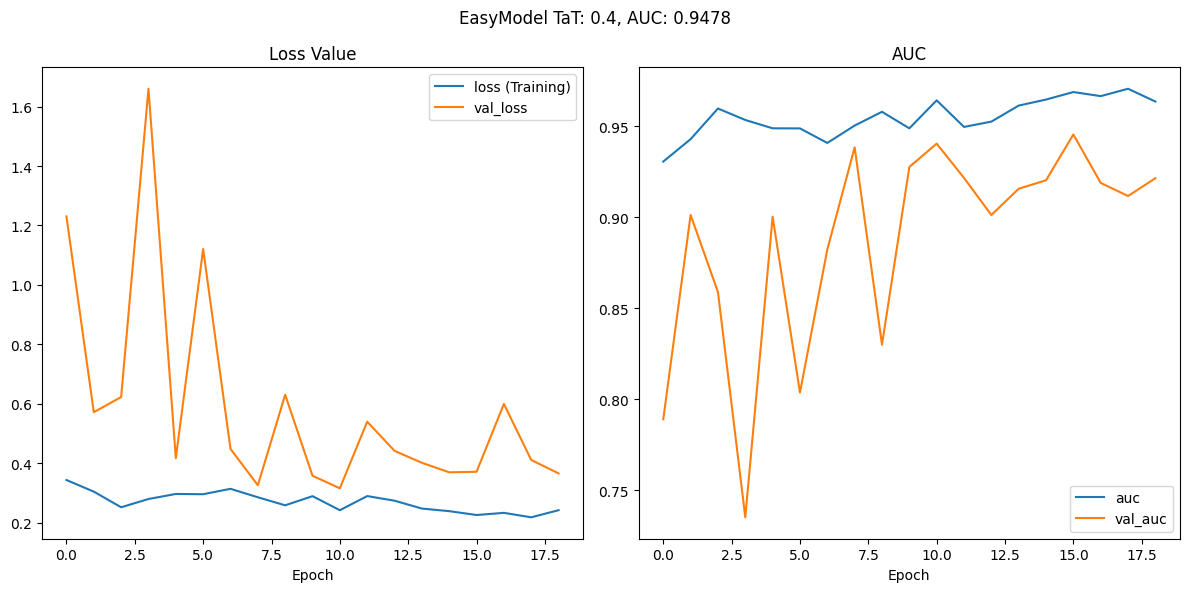

Train loss: 0.2415534406900406
Test val_loss: 0.3653815686702728
AUC: 0.9477821448624368
Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.93      0.86       137
         1.0       0.93      0.78      0.85       156

    accuracy                           0.85       293
   macro avg       0.86      0.86      0.85       293
weighted avg       0.87      0.85      0.85       293



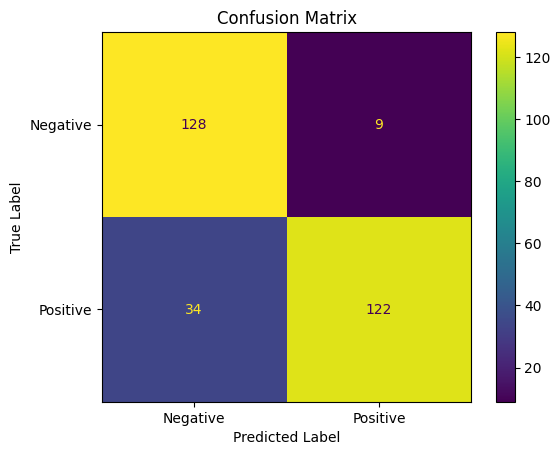

In [15]:
model.compile(optimizer=Adam(learning_rate=0.004), loss='binary_crossentropy', metrics=['auc'])  # Change metric to 'auc'
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val), 
                    callbacks=[early_stopping], verbose=1) 
# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate AUC
auc = roc_auc_score(y_test, y_pred)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot AUC
axs[1].plot(history.history["auc"], label="auc")
axs[1].plot(history.history["val_auc"], label="val_auc")
axs[1].set_title("AUC")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, AUC: {auc:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("AUC:", auc)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

plot_confusion_matrix(y_test, y_pred_binary)

# ARTICULATED BRANCH

/home/rl_sim/anaconda3/envs/tfenv/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 800, 5)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 4000)      │          0 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 256)       │  1,024,256 │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_28[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 128)       │    512,128 │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 128)       │    512,128 │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 128)       │          0 │ dense_30[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 128)       │          0 │ dense_32[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 64)        │    256,064 │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 128)       │     32,896 │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 64)        │      8,256 │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 64)        │      8,256 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 32)        │      2,080 │ dense_34[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 288)       │          0 │ dense_29[0][0],   │
│ (Concatenate)       │                   │            │ dense_31[0][0],   │
│                     │                   │            │ dense_33[0][0],   │
│                     │                   │            │ dense_35[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 288)       │      1,152 │ concatenate_1[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 128)       │     36,992 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 64)        │      8,256 │ dense_36[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 64)        │      8,256 │ dense_36[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 64)        │      8,256 │ dense_36[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,432,897 (9.28 MB)

 Trainable params: 2,431,617 (9.28 MB)

 Non-trainable params: 1,280 (5.00 KB)

Epoch 1/25


 1/28 ━━━━━━━━━━━━━━━━━━━━ 2:34 6s/step - accuracy: 0.5625 - loss: 0.8032

I0000 00:00:1725033562.397059  675953 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_11', 8 bytes spill stores, 8 bytes spill loads



28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.6016 - loss: 0.6837

I0000 00:00:1725033565.495432  676123 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5', 8 bytes spill stores, 8 bytes spill loads



28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 193ms/step - accuracy: 0.6027 - loss: 0.6821 - val_accuracy: 0.4915 - val_loss: 4.8741
Epoch 2/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7403 - loss: 0.5078 - val_accuracy: 0.6826 - val_loss: 2.1906
Epoch 3/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7295 - loss: 0.5868 - val_accuracy: 0.7031 - val_loss: 0.7751
Epoch 4/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7733 - loss: 0.4913 - val_accuracy: 0.7167 - val_loss: 0.8130
Epoch 5/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8051 - loss: 0.4223 - val_accuracy: 0.7270 - val_loss: 0.6269
Epoch 6/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8241 - loss: 0.4130 - val_accuracy: 0.6928 - val_loss: 0.8627
Epoch 7/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8210 - loss: 0.3966 - val_accuracy: 0.7474 - val_loss: 0.4877
Epoch 8/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8185 - loss: 0.4196 - val_accuracy: 0.7850 - val_loss: 0.5269


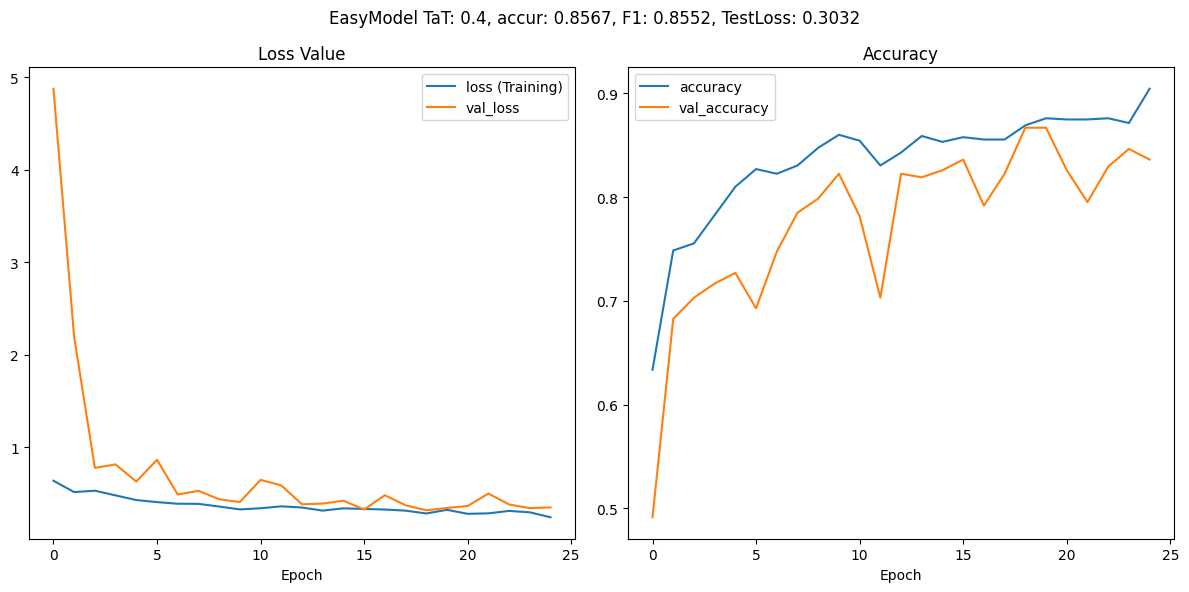

Train loss: 0.24112603068351746
Test val_loss: 0.34770604968070984
Train accuracy: 0.9044368863105774
Accuracy Score: 0.856655290102389
F1 Score: 0.8551724137931035
Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.93      0.86       137
         1.0       0.93      0.79      0.86       156

    accuracy                           0.86       293
   macro avg       0.86      0.86      0.86       293
weighted avg       0.87      0.86      0.86       293



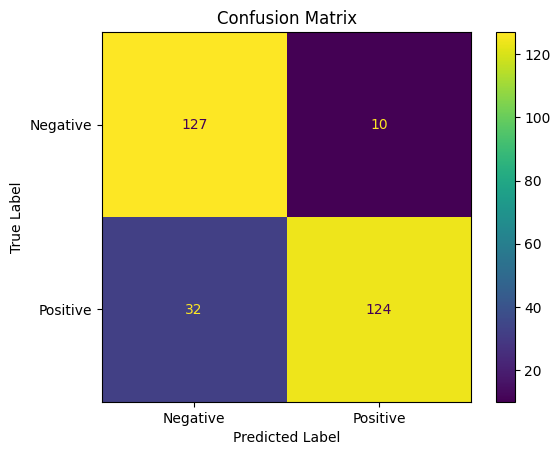

In [16]:
from tensorflow.keras.initializers import GlorotUniform

def build_ff_ann(input_shape=IN_SHAPE):
    input_layer = Input(shape=input_shape)
    flatten_layer = Flatten()(input_layer)  # Add a flatten layer
    
    # Branch 1
    branch1 = Dense(256, activation='relu')(flatten_layer)
    branch1 = BatchNormalization()(branch1)
    branch1 = Dropout(0.2)(branch1)
    branch1_output = Dense(128, activation='relu')(branch1)
    
    # Branch 2
    branch2 = Dense(128, activation='relu')(flatten_layer)
    branch2 = Dropout(0.2)(branch2)
    branch2_output = Dense(64, activation='relu')(branch2)
    
    # Branch 3
    branch3 = Dense(128, activation='relu')(flatten_layer)
    branch3 = Dropout(0.2)(branch3)
    branch3_output = Dense(64, activation='relu')(branch3)
    
    # Branch 4
    branch4 = Dense(64, activation='relu')(flatten_layer)
    branch4_output = Dense(32, activation='relu')(branch4)

    # Merge the first four branches
    merged = concatenate([branch1_output, branch2_output, branch3_output, branch4_output])
    merged = BatchNormalization()(merged)
    merged = Dense(128, activation='relu')(merged)
    
    # Split into three new branches
    branch5 = Dense(64, activation='relu')(merged)
    branch5 = Dropout(0.2)(branch5)
    branch5_output = Dense(32, activation='relu')(branch5)
    
    branch6 = Dense(64, activation='relu')(merged)
    branch6 = Dropout(0.2)(branch6)
    branch6_output = Dense(32, activation='relu')(branch6)
    
    branch7 = Dense(64, kernel_initializer=GlorotUniform())(merged)
    branch7 = LeakyReLU(alpha=0.1)(branch7)
    branch7 = Dropout(0.2)(branch7)
    branch7_output = Dense(32, kernel_initializer=GlorotUniform(), activation='relu')(branch7)
    
    # Merge the three branches
    final_merge = concatenate([branch5_output, branch6_output, branch7_output])
    final_merge = BatchNormalization()(final_merge)
    final_merge = Dense(64, activation='relu')(final_merge)
    
    # Output layer
    output_layer = Dense(1, activation='sigmoid')(final_merge)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

# To create the model
model = build_ff_ann()
model.summary()

model.compile(optimizer=Adam(learning_rate=0.004), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val), 
                    callbacks=[early_stopping], verbose=1) 
loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

plot_confusion_matrix(y_test, y_pred_binary)

In [17]:
# model_name = f"FF_{TYPEm}_ArticulatedModel_v1"
# from ML_models_functions import save_summary_and_results
# save_summary_and_results(model, history, loss, accuracy, f1, model_name, y_test, y_pred_binary, build_ff_ann)
# # Save the model separately
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)